## Imports

In [1]:
import jupyter_black

import sys
import numpy as np
import matplotlib.pyplot as plt

jupyter_black.load()

if "/usr/src" not in sys.path:
    sys.path.append("/usr/src")

In [2]:
# Import torch modules
import torch
import torchvision.transforms as tfs
from torchvision.utils import make_grid
from torch.utils.data import DataLoader


import lightning.pytorch as pl


# Import custom modules
import data.dataset, data.transform
from data.utils import cut_substrates

from models.substrates.encoder import Encoder
from models.substrates.decoder import Decoder
from models.substrates.vae import VariationalAutoEncoder

## Settings

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
RANDOM_SEED = 42
LEARNING_RATE = 0.0005
NUM_EPOCHS = 100
BATCH_SIZE = 128
IMAGE_SIZE = (178, 256)
LATENT_SIZE = 5
RECONSTRUCTION_TERM_WEIGHT = 1

## Prepare dataset

In [4]:
segmentation_dir = "/usr/src/data/segmentation_object"
image_dir = "/usr/src/data/source_images"
substrate_dir = "/usr/src/data/substrates"
part_substrate_dir = "/usr/src/data/part_substrates"

In [ ]:
cut_substrates(segmentation_dir, image_dir, substrate_dir, part_substrate_dir)

In [5]:
transform = tfs.Compose([tfs.ToPILImage(), tfs.ToTensor()])

dataset = data.dataset.SubstratesImageDataset(part_substrate_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

## Model

In [6]:
encoder = Encoder(LATENT_SIZE)
decoder = Decoder(IMAGE_SIZE, LATENT_SIZE)
VAE = VariationalAutoEncoder(encoder, decoder, LEARNING_RATE)

## Train

In [8]:
trainer = pl.Trainer(max_epochs=NUM_EPOCHS, log_every_n_steps=4)
trainer.fit(model=VAE, train_dataloaders=train_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To prope

Training: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


## Generate samples

In [11]:
def generate_and_plot(model, n_images, device, image_name=""):
    latent_size = model.latent_size
    with torch.no_grad():
        rand_features = torch.randn(n_images, latent_size).to(device)
        generated_images = model.decoder(rand_features)

    grid = make_grid(generated_images, nrow=int(np.sqrt(n_images)))
    grid = grid.detach().to(torch.device("cpu"))
    grid = np.transpose(grid.numpy(), (1, 2, 0))
    plt.imshow(grid, cmap="gray", vmin=0, vmax=255)
    plt.xticks([])
    plt.yticks([])

    if image_name:
        plt.imsave(image_name, grid, cmap="gray")


def show_images_bar(images: list[np.ndarray], cmap="gray", titles=[]):
    n_images = len(images)
    _, axes = plt.subplots(1, n_images)
    axes = np.array(axes)

    for ax, img in zip(axes.flat, images):
        if len(img.shape) > 2:
            ax.imshow(img)
        else:
            ax.imshow(img, cmap=cmap)
        ax.set(xticks=[], yticks=[])

    if titles:
        for ax, title in zip(axes.flat, titles):
            ax.set_title(title)

In [9]:
n_images = 10

with torch.no_grad():
    features = next(iter(train_loader))
    orig_images = features[:n_images].to(DEVICE)
    VAE = VAE.to(DEVICE)
    encoded_images = VAE.encoder(orig_images)[0]
    decoded_images = VAE.decoder(encoded_images)

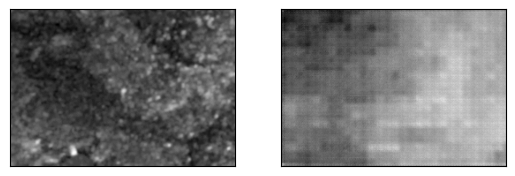

In [12]:
i = 1
image = orig_images[i].cpu().view(178, 256)
decoded_image = decoded_images[i].cpu().view(178, 256)
show_images_bar([image, decoded_image])

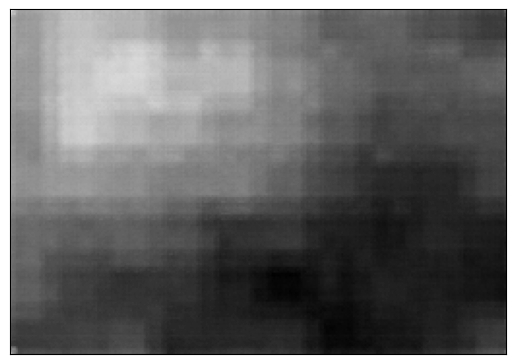

In [18]:
noise = torch.randn((1, LATENT_SIZE)).to(DEVICE)
with torch.no_grad():
    generated = VAE.decoder(noise)
show_images_bar([generated.cpu().view(178, 256)])